In [1]:
import os
import konlpy
import gensim
import pandas as pd
import tensorflow as tf

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


### 1) 데이터 준비와 확인

In [2]:
file_path = os.getenv('HOME') + '/aiffel/aiffel_quest/mini_quest_240322/data/'

train_data = pd.read_table(file_path + 'ratings_train.txt')
test_data = pd.read_table(file_path + 'ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 2) 데이터로더 구성

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words=10000

def load_data(train_data, test_data, num_words=num_words):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNUSED>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)



In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨:',y_train[0])

더 빙 . . 진짜 짜증 나 네요 목소리
라벨: 0


### 3) 모델 구성을 위한 데이터 분석 및 가공

In [11]:
# 데이터셋 내 문장 길이 분포

In [12]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [13]:
# 적절한 최대 문장 길이 지정

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


maxlen: 41을 확인

In [14]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [15]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [16]:
X_train

array([[   0,    0,    0, ...,   20,   33,  748],
       [   0,    0,    0, ...,   15,   44,  391],
       [   0,    0,    0, ...,   24,  205,    3],
       ...,
       [   0,    0,    0, ..., 2710,    6,   18],
       [   0,    0,    0, ...,   60,  395, 8572],
       [   0,    0,    0, ...,   88, 2740,    5]], dtype=int32)

### 4) 모델 구성 및 validation set 구성

In [17]:
# 모델은 3가지 이상 다양하게 구성하여 실험

In [26]:
vocab_size = 10000  
word_vector_dim = 32  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 
batch_size = 16

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 321,393
Trainable params: 321,393
Non-trainable params: 0
_________________________________________________________________


In [19]:
model_2=tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(tf.keras.layers.GlobalMaxPooling1D())
model_2.add(tf.keras.layers.Dense(8, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 320,273
Trainable params: 320,273
Non-trainable params: 0
_________________________________________________________________


In [20]:
model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_3.add(tf.keras.layers.MaxPooling1D(5))
model_3.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_3.add(tf.keras.layers.GlobalMaxPooling1D())
model_3.add(tf.keras.layers.Dense(8, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          3600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [21]:
from sklearn.model_selection import train_test_split

# 데이터를 train:test:valid = 6:2:2 비율로 나누기
# train:test 비율 = 3:1
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

# 나머지 60% 중에서 test:valid 비율 = 1:1
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 각 데이터셋의 크기 확인
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("X_valid.shape:", X_valid.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)
print("y_valid.shape:", y_valid.shape)


X_train.shape: (87709, 41)
X_test.shape: (29236, 41)
X_valid.shape: (29237, 41)
y_train.shape: (87709,)
y_test.shape: (29236,)
y_valid.shape: (29237,)


### 5) 모델 훈련 개시

In [22]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

              
history = model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_valid,y_valid))

# 훈련 및 테스트 정확도 출력
train_accuracy = history.history['accuracy'][-1]
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("훈련 정확도:", train_accuracy)
print("테스트 정확도:", test_accuracy)

Epoch 1/20
2741/2741 [==============================] - 18s 5ms/step - loss: 0.3946 - accuracy: 0.8229 - val_loss: 0.3512 - val_accuracy: 0.8439
Epoch 2/20
2741/2741 [==============================] - 14s 5ms/step - loss: 0.3086 - accuracy: 0.8678 - val_loss: 0.3389 - val_accuracy: 0.8496
Epoch 3/20
2741/2741 [==============================] - 14s 5ms/step - loss: 0.2695 - accuracy: 0.8870 - val_loss: 0.3497 - val_accuracy: 0.8542
Epoch 4/20
2741/2741 [==============================] - 14s 5ms/step - loss: 0.2342 - accuracy: 0.9034 - val_loss: 0.3640 - val_accuracy: 0.8524
Epoch 5/20
2741/2741 [==============================] - 14s 5ms/step - loss: 0.2045 - accuracy: 0.9175 - val_loss: 0.3888 - val_accuracy: 0.8486
Epoch 6/20
2741/2741 [==============================] - 14s 5ms/step - loss: 0.1779 - accuracy: 0.9293 - val_loss: 0.4267 - val_accuracy: 0.8464
Epoch 7/20
2741/2741 [==============================] - 14s 5ms/step - loss: 0.1537 - accuracy: 0.9414 - val_loss: 0.4495 - val_ac

In [27]:
# 모델 컴파일
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

              
history_2 = model_2.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_valid,y_valid))

# 훈련 및 테스트 정확도 출력
train_accuracy = history_2.history['accuracy'][-1]
test_loss, test_accuracy = model_2.evaluate(X_test, y_test)

print("훈련 정확도:", train_accuracy)
print("테스트 정확도:", test_accuracy)

Epoch 1/20
5482/5482 [==============================] - 19s 3ms/step - loss: 0.4430 - accuracy: 0.8086 - val_loss: 0.3761 - val_accuracy: 0.8386
Epoch 2/20
5482/5482 [==============================] - 18s 3ms/step - loss: 0.3264 - accuracy: 0.8647 - val_loss: 0.3638 - val_accuracy: 0.8439
Epoch 3/20
5482/5482 [==============================] - 18s 3ms/step - loss: 0.2844 - accuracy: 0.8834 - val_loss: 0.3723 - val_accuracy: 0.8380
Epoch 4/20
5482/5482 [==============================] - 18s 3ms/step - loss: 0.2543 - accuracy: 0.8974 - val_loss: 0.3835 - val_accuracy: 0.8412
Epoch 5/20
5482/5482 [==============================] - 18s 3ms/step - loss: 0.2306 - accuracy: 0.9082 - val_loss: 0.4025 - val_accuracy: 0.8378
Epoch 6/20
5482/5482 [==============================] - 18s 3ms/step - loss: 0.2093 - accuracy: 0.9184 - val_loss: 0.4312 - val_accuracy: 0.8349
Epoch 7/20
5482/5482 [==============================] - 18s 3ms/step - loss: 0.1914 - accuracy: 0.9267 - val_loss: 0.4455 - val_ac

In [28]:
# 모델 컴파일
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

              
history_3 = model_3.fit(X_train, y_train, epochs=20,batch_size=batch_size, validation_data=(X_valid,y_valid))

# 훈련 및 테스트 정확도 출력
train_accuracy = history_3.history['accuracy'][-1]
test_loss, test_accuracy = model_3.evaluate(X_test, y_test)

print("훈련 정확도:", train_accuracy)
print("테스트 정확도:", test_accuracy)

Epoch 1/20
5482/5482 [==============================] - 25s 4ms/step - loss: 0.3851 - accuracy: 0.8212 - val_loss: 0.3404 - val_accuracy: 0.8492
Epoch 2/20
5482/5482 [==============================] - 24s 4ms/step - loss: 0.2750 - accuracy: 0.8862 - val_loss: 0.3441 - val_accuracy: 0.8507
Epoch 3/20
5482/5482 [==============================] - 24s 4ms/step - loss: 0.1986 - accuracy: 0.9224 - val_loss: 0.3791 - val_accuracy: 0.8452
Epoch 4/20
5482/5482 [==============================] - 24s 4ms/step - loss: 0.1374 - accuracy: 0.9491 - val_loss: 0.4439 - val_accuracy: 0.8385
Epoch 5/20
5482/5482 [==============================] - 24s 4ms/step - loss: 0.0972 - accuracy: 0.9655 - val_loss: 0.5802 - val_accuracy: 0.8301
Epoch 6/20
5482/5482 [==============================] - 24s 4ms/step - loss: 0.0741 - accuracy: 0.9730 - val_loss: 0.6661 - val_accuracy: 0.8284
Epoch 7/20
5482/5482 [==============================] - 24s 4ms/step - loss: 0.0608 - accuracy: 0.9778 - val_loss: 0.7391 - val_ac

### 6) Loss, Accuracy 그래프 시각화

In [29]:
history_dict = history.history
print(history_dict.keys())

history_dict_2 = history_2.history
print(history_dict_2.keys())

history_dict_3 = history_3.history
print(history_dict_3.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


#### 첫번째 모델 그래프

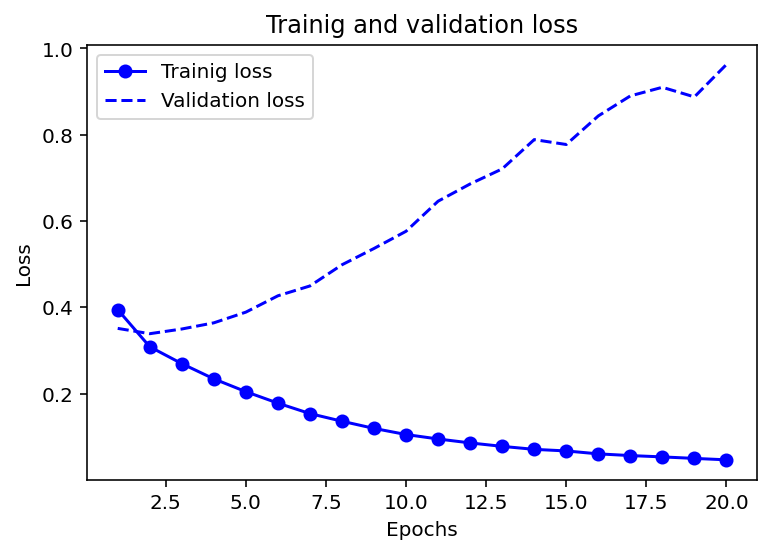

In [30]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo-', label='Trainig loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Trainig and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

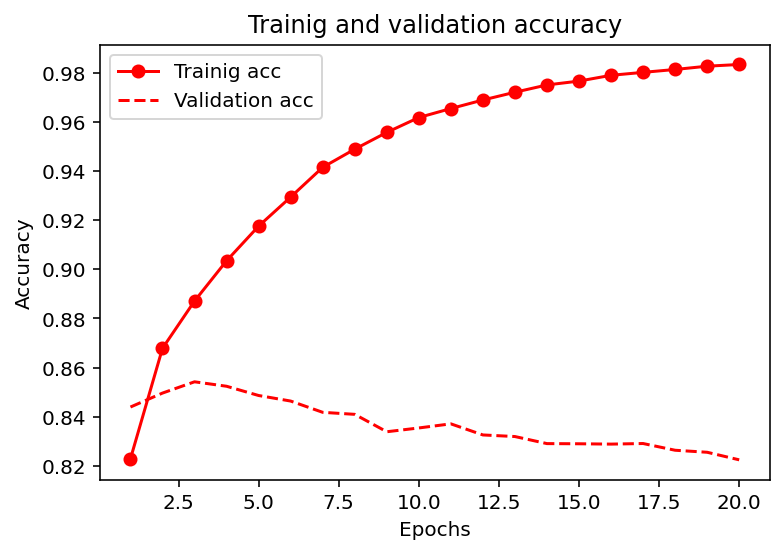

In [31]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'ro-', label='Trainig acc')
plt.plot(epochs, val_acc ,'r--', label='Validation acc')
plt.title('Trainig and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 두번째 모델 그래프

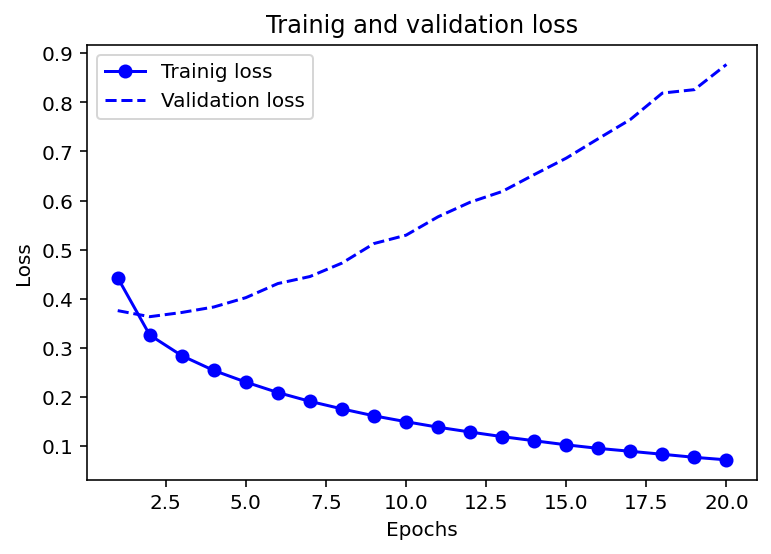

In [32]:
acc = history_dict_2['accuracy']
val_acc = history_dict_2['val_accuracy']
loss = history_dict_2['loss']
val_loss = history_dict_2['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo-', label='Trainig loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Trainig and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

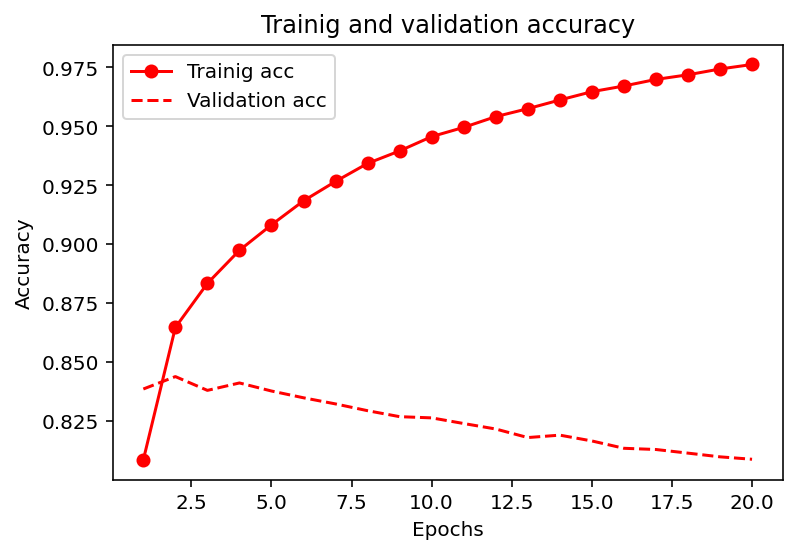

In [33]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'ro-', label='Trainig acc')
plt.plot(epochs, val_acc ,'r--', label='Validation acc')
plt.title('Trainig and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 세번째 모델 그래프

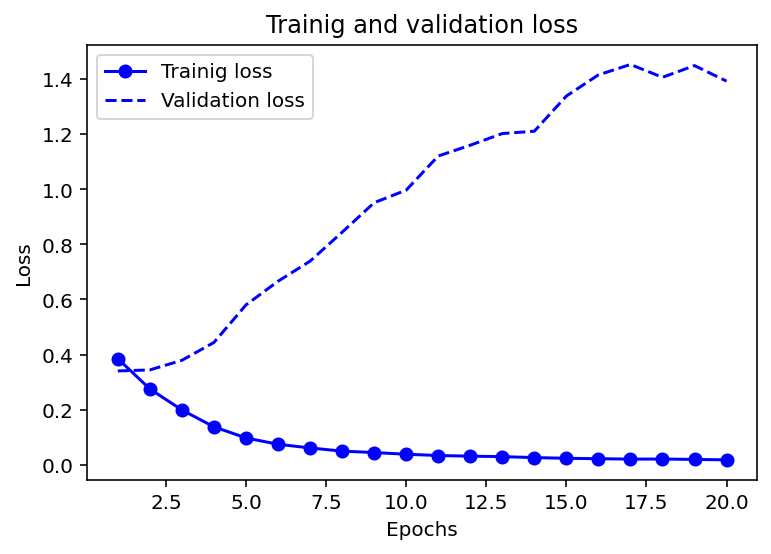

In [34]:
acc = history_dict_3['accuracy']
val_acc = history_dict_3['val_accuracy']
loss = history_dict_3['loss']
val_loss = history_dict_3['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo-', label='Trainig loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Trainig and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

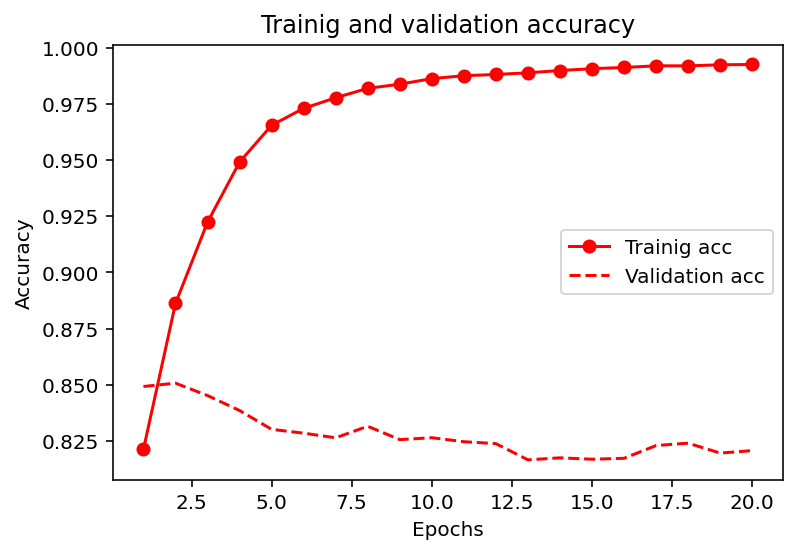

In [35]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'ro-', label='Trainig acc')
plt.plot(epochs, val_acc ,'r--', label='Validation acc')
plt.title('Trainig and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [36]:
embedding_layer = model_3.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 32)


In [37]:
# # 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/aiffel_quest/mini_quest_240322/data/naver_moive_review.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_3.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [38]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['목소리']
vector

array([ 0.13184366, -0.3093387 , -0.31113318, -0.23649715, -0.6974667 ,
       -0.37313482, -0.22212599,  0.14196686, -0.0696526 , -0.21988125,
        0.20496897,  0.1552484 ,  0.11417567,  0.52414465,  0.07128344,
        0.32505596, -0.5407056 ,  0.0632969 ,  0.5397229 , -0.00124331,
        0.18493174,  0.40218177, -0.00705737, -0.2705515 ,  0.26602054,
       -0.16135946,  0.12227935,  0.00410242,  0.03231604,  0.0435643 ,
       -0.34018734,  0.26702273], dtype=float32)

In [39]:
word_vectors.similar_by_word("감독")

[('마구잡이', 0.72088623046875),
 ('기대치', 0.6725185513496399),
 ('송혜교', 0.667529284954071),
 ('기르', 0.6630521416664124),
 ('누굴', 0.6567368507385254),
 ('아무거', 0.6522374153137207),
 ('스트레스', 0.6506167054176331),
 ('가져다', 0.6386110782623291),
 ('지르', 0.6321668028831482),
 ('투자', 0.6287485957145691)]

In [40]:
word_vectors.similar_by_word("스릴러")

[('녹아들', 0.7058758735656738),
 ('들려', 0.7037950754165649),
 ('인데요', 0.6972512006759644),
 ('겠다는', 0.6544250845909119),
 ('못된', 0.6511133909225464),
 ('작인', 0.6485301852226257),
 ('손오공', 0.6473536491394043),
 ('풀리', 0.6400561928749084),
 ('컴퓨터', 0.6396827697753906),
 ('여름', 0.6394026875495911)]

In [41]:
word_vectors.similar_by_word("아이언맨")

[('쨩', 0.8054007291793823),
 ('크리스토퍼', 0.799763023853302),
 ('당연', 0.7931528687477112),
 ('*^^*', 0.7907425761222839),
 ('오호', 0.7865269184112549),
 ('박진감', 0.7798355221748352),
 ('메이드', 0.7778984904289246),
 ('던진', 0.7744325399398804),
 ('짱짱', 0.7736276984214783),
 ('오싹', 0.7640470266342163)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 - 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. [참고 링크1](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models), [참고 링크2](https://radimrehurek.com/gensim/models/keyedvectors.html)

In [46]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/aiffel_quest/mini_quest_240322/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path)


In [52]:
vector = word_vectors.wv['목소리']
print(vector)
print(vector.shape)

[ 0.39437878 -1.0463755  -1.3038353  -0.39039278  0.29594433 -0.05617345
 -1.9029323  -4.790772    1.01974     1.0057237  -1.0435585   0.54053444
 -0.9981419  -3.2532756   0.24951148  1.6071857   0.2836816  -0.9386404
  2.851765   -1.3541062  -2.3923109   2.2244053   0.22609589 -2.192533
 -0.4919802  -1.0304679  -0.663316    0.09172083 -0.87570095 -2.275621
 -4.3960576  -0.6402974  -3.2612407   0.84830415 -0.33028322  1.0334612
 -2.1874292   2.7219095  -1.3813906   2.1179664   2.1909595  -0.7569393
  2.8278058   4.062249   -1.606891   -0.06783267  4.485126   -2.9872847
  0.33473065 -4.7628183   1.6443961  -1.5706344   2.3660967  -1.3017995
 -2.1736336  -0.7299461   2.6115205  -3.5877519   0.6634793  -0.30191502
  4.473395    0.7479291  -1.9621661  -6.4965405  -1.5372211  -0.65765196
 -1.0497555  -0.59557784 -0.6242912  -0.39645424  1.2851491   2.4460611
 -2.5253575   4.278156   -2.4087563  -0.10586937 -0.2969541  -3.294575
 -2.2453716  -0.95259917  0.01129699 -1.5282934  -2.070059   -1

In [48]:
word_vectors.wv.similar_by_word("아이언맨")

[('스파이더맨', 0.8396747708320618),
 ('터미네이터', 0.8001936078071594),
 ('스타워즈', 0.7816243767738342),
 ('엑스맨', 0.7741316556930542),
 ('워크래프트', 0.756368100643158),
 ('록맨', 0.7465384602546692),
 ('어벤져스', 0.7381415963172913),
 ('트랜스포머', 0.7348647117614746),
 ('크리드', 0.7308904528617859),
 ('GTA', 0.7282211780548096)]

In [50]:
word_vectors.wv.similar_by_word("스릴러")

[('코미디', 0.8267820477485657),
 ('로맨스', 0.7384023666381836),
 ('액션', 0.7381717562675476),
 ('스릴러물', 0.6885045170783997),
 ('SF', 0.6855127215385437),
 ('미스터리', 0.6853450536727905),
 ('로맨틱', 0.6521303653717041),
 ('영화', 0.6241381764411926),
 ('서스펜스', 0.6102020144462585),
 ('판타지', 0.5968810319900513)]

In [51]:
word_vectors.wv.similar_by_word("감독")

[('총감독', 0.7736535668373108),
 ('조감독', 0.6690524816513062),
 ('사령탑', 0.6605908274650574),
 ('히딩크', 0.6478949785232544),
 ('코치', 0.6429321765899658),
 ('과르디올라', 0.6207290291786194),
 ('구단주', 0.6140843033790588),
 ('후임', 0.613168478012085),
 ('황선홍', 0.6077929139137268),
 ('신태용', 0.5978867411613464)]

In [54]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [55]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [58]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_valid,y_valid),
                    verbose=1)

Epoch 1/20
5482/5482 [==============================] - 26s 5ms/step - loss: 0.4725 - accuracy: 0.7682 - val_loss: 0.3890 - val_accuracy: 0.8246
Epoch 2/20
5482/5482 [==============================] - 25s 5ms/step - loss: 0.3495 - accuracy: 0.8463 - val_loss: 0.3547 - val_accuracy: 0.8427
Epoch 3/20
5482/5482 [==============================] - 25s 5ms/step - loss: 0.3077 - accuracy: 0.8685 - val_loss: 0.3570 - val_accuracy: 0.8450
Epoch 4/20
5482/5482 [==============================] - 25s 5ms/step - loss: 0.2778 - accuracy: 0.8837 - val_loss: 0.3537 - val_accuracy: 0.8473
Epoch 5/20
5482/5482 [==============================] - 25s 5ms/step - loss: 0.2524 - accuracy: 0.8955 - val_loss: 0.3752 - val_accuracy: 0.8438
Epoch 6/20
5482/5482 [==============================] - 25s 5ms/step - loss: 0.2283 - accuracy: 0.9071 - val_loss: 0.3784 - val_accuracy: 0.8453
Epoch 7/20
5482/5482 [==============================] - 25s 5ms/step - loss: 0.2059 - accuracy: 0.9179 - val_loss: 0.3889 - val_ac

In [59]:
print("훈련 정확도:", train_accuracy)
print("테스트 정확도:", test_accuracy)

훈련 정확도: 0.9925777316093445
테스트 정확도: 0.8190245032310486


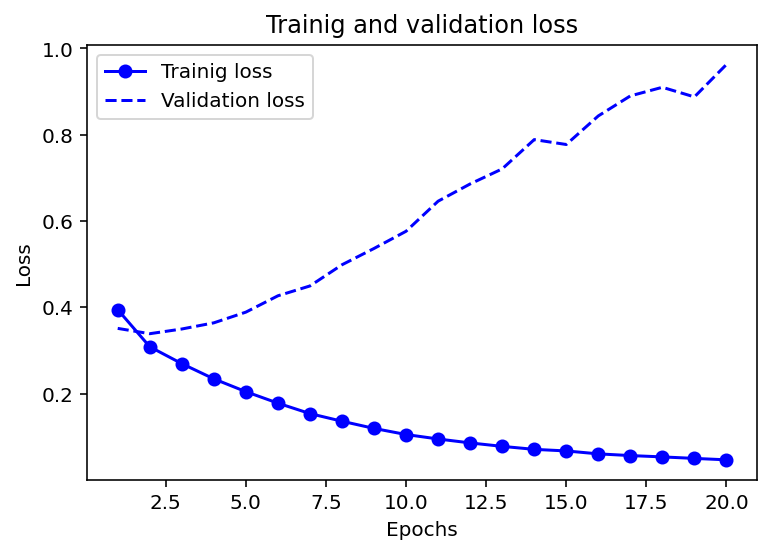

In [60]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo-', label='Trainig loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Trainig and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

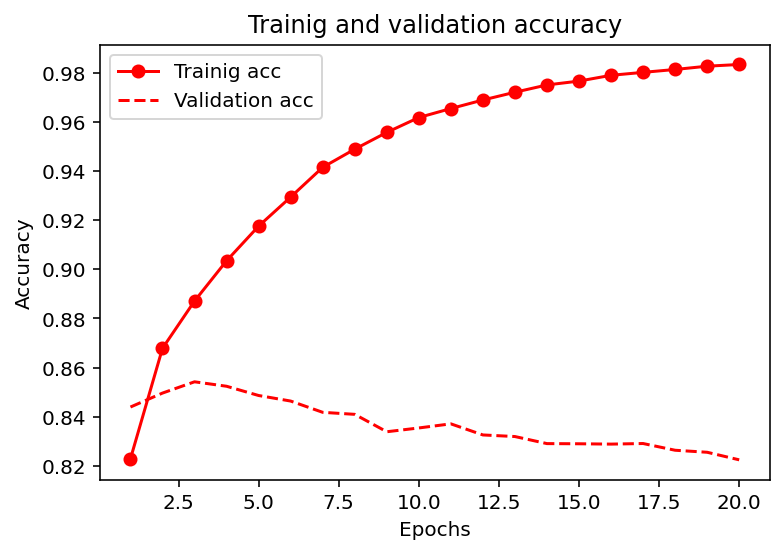

In [61]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'ro-', label='Trainig acc')
plt.plot(epochs, val_acc ,'r--', label='Validation acc')
plt.title('Trainig and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()